In [1]:
import os
import time
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from collections import Counter

# Define the folder containing the images
image_folder = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images'

# Paths to the text files
train_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_manufacturer_train.txt'
test_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_manufacturer_test.txt'
val_label_file = '/Users/louieburns/Library/CloudStorage/OneDrive-UniversityofLeeds/Year 3/AI and Machine Learning/Term 1/Coursework 1/Actual Coursework/dataoriginal/images_manufacturer_trainval.txt'

# Define label mapping
label_mapping = {
    "Boeing": 0,
    "Airbus": 1,
    "ATR": 2,
    "Antonov": 3,
    "BritishAerospace": 4,
    "Beechcraft": 5,
    "LockheedCorporation": 6,
    "DouglasAircraftCompany": 7,
    "Canadair": 8,
    "Cessna": 9,
    "McDonnellDouglas": 10,
    "deHavilland": 11,
    "Robin": 12,
    "Dornier": 13,
    "Embraer": 14,
    "Eurofighter": 15,
    "LockheedMartin": 16,
    "DassaultAviation": 17,
    "Fokker": 18,
    "BombardierAerospace": 19,
    "GulfstreamAerospace": 20,
    "Ilyushin": 21,
    "Fairchild": 22,
    "Piper": 23,
    "CirrusAircraft": 24,
    "Saab": 25,
    "Supermarine": 26,
    "Panavia": 27,
    "Tupolev": 28,
    "Yakovlev": 29
}

def select_balanced_classes(train_file, val_file, test_file, label_mapping, num_classes=5):
    def count_labels(file_path):
        counts = Counter()
        with open(file_path, "r") as f:
            for line in f:
                _, label = line.strip().split(maxsplit=1)
                if label in label_mapping:
                    counts[label] += 1
        return counts

    train_counts = count_labels(train_file)
    val_counts = count_labels(val_file)
    test_counts = count_labels(test_file)

    # Combine counts for all datasets
    combined_counts = {label: train_counts[label] + val_counts[label] + test_counts[label] for label in label_mapping}
    
    # Sort by total count and select top labels
    selected_labels = dict(sorted(combined_counts.items(), key=lambda item: item[1], reverse=True)[:num_classes])
    
    # Map selected labels to indices
    selected_labels = {label: idx for idx, (label, _) in enumerate(selected_labels.items())}

    return selected_labels

# Intelligently select classes based on data distribution
selected_labels = select_balanced_classes(train_label_file, val_label_file, test_label_file, label_mapping)


# Define transformations for image processing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(5),    # Random rotation up to 15 degrees
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize([0.5], [0.5])  # Normalize
])

def filter_data(label_file, selected_labels):
    image_data = []
    labels = []

    with open(label_file, "r") as f:
        for line in f:
            parts = line.strip().split(maxsplit=1)
            if len(parts) != 2:
                continue  # Skip malformed lines
            filename, label = parts
            if label in selected_labels:
                image_path = os.path.join(image_folder, filename + ".jpg")
                try:
                    if os.path.exists(image_path):
                        image = Image.open(image_path).convert("RGB")
                        image_tensor = transform(image)
                        image_data.append(image_tensor)
                        labels.append(selected_labels[label])
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")

    # Convert lists to PyTorch tensors
    image_tensor = torch.stack(image_data)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return image_tensor, label_tensor, labels




In [2]:
# Process training, validation, and test data for selected labels
train_image_tensor, train_label_tensor, train_labels = filter_data(train_label_file, selected_labels)
val_image_tensor, val_label_tensor, val_labels = filter_data(val_label_file, selected_labels)
test_image_tensor, test_label_tensor, test_labels = filter_data(test_label_file, selected_labels)

# Print dataset sizes
print(f"Number of training images: {len(train_image_tensor)}")
print(f"Number of validation images: {len(val_image_tensor)}")
print(f"Number of test images: {len(test_image_tensor)}")

# Print counts for each class in training, validation, and test datasets
train_counts = Counter(train_labels)
val_counts = Counter(val_labels)
test_counts = Counter(test_labels)

print("Training dataset class distribution:")
for label, count in train_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Validation dataset class distribution:")
for label, count in val_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

print("Test dataset class distribution:")
for label, count in test_counts.items():
    print(f"{list(selected_labels.keys())[list(selected_labels.values()).index(label)]}: {count}")

# Create TensorDatasets
train_dataset = TensorDataset(train_image_tensor, train_label_tensor)
val_dataset = TensorDataset(val_image_tensor, val_label_tensor)
test_dataset = TensorDataset(test_image_tensor, test_label_tensor)

# Example usage of DataLoader
batch_size = 32  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("DataLoaders for selected labels created successfully.")

# Define a simplified CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 64 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 64 * 64, len(selected_labels))
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = x.view(-1, 16 * 64 * 64)
        x = self.fc1(x)
        return x

# Instantiate the simplified model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Fixed learning rate

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=9, gamma=0.5)  # Decays learning rate by 0.5 every 9 epochs

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
f1_scores = []
learning_rates = []

# Training loop
num_epochs = 40  # Increased number of epochs
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Step the scheduler
    scheduler.step()
    learning_rates.append(scheduler.get_last_lr()[0])

    train_accuracy = correct_train / total_train

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    test_accuracy = correct_test / total_test
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Store metrics
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(test_loss / len(test_loader))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    f1_scores.append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, F1 Score: {f1:.4f}, Learning Rate: {scheduler.get_last_lr()[0]}")

print("Training complete.")

# Create Epochs for plotting results
epochs = range(1, num_epochs + 1)

Number of training images: 1667
Number of validation images: 3333
Number of test images: 1667
Training dataset class distribution:
Boeing: 733
Airbus: 434
Canadair: 134
Cessna: 133
Embraer: 233
Validation dataset class distribution:
Boeing: 1466
Airbus: 867
Canadair: 267
Cessna: 266
Embraer: 467
Test dataset class distribution:
Boeing: 734
Airbus: 433
Canadair: 133
Cessna: 134
Embraer: 233
DataLoaders for selected labels created successfully.
Epoch [1/40], Train Loss: 8.9874, Test Loss: 2.9319, Train Acc: 0.3431, Test Acc: 0.2100, F1 Score: 0.1483, Learning Rate: 0.01
Epoch [2/40], Train Loss: 1.3026, Test Loss: 3.8430, Train Acc: 0.4823, Test Acc: 0.2681, F1 Score: 0.1427, Learning Rate: 0.01
Epoch [3/40], Train Loss: 1.2302, Test Loss: 1.7671, Train Acc: 0.5165, Test Acc: 0.4415, F1 Score: 0.3136, Learning Rate: 0.01
Epoch [4/40], Train Loss: 1.0317, Test Loss: 1.4968, Train Acc: 0.5783, Test Acc: 0.3509, F1 Score: 0.3113, Learning Rate: 0.01
Epoch [5/40], Train Loss: 0.9395, Test Lo

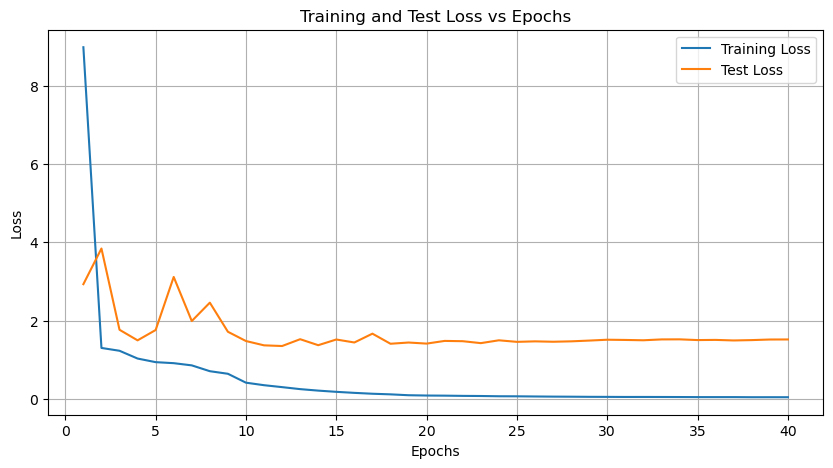

In [3]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

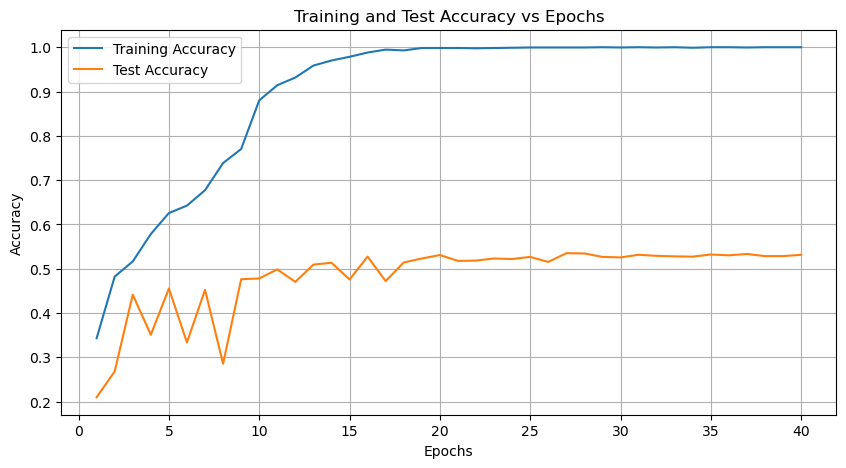

In [4]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.legend()
plt.grid(True)
plt.show()  

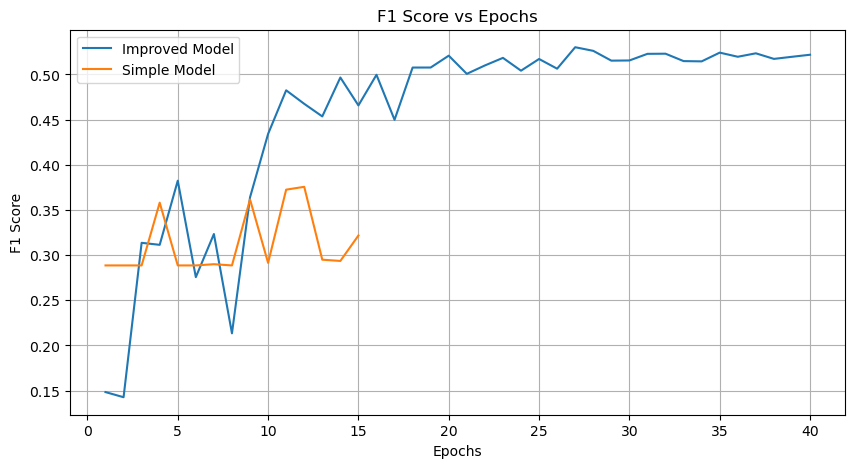

In [5]:
# Plot F1 Score
plt.figure(figsize=(10, 5))

# Improved Model F1 Scores
plt.plot(epochs, f1_scores, linestyle='-', label="Improved Model")

# Plot the F1 values from the Baseline Model, this is hard-coded in
plt.plot(
    range(1, 16), 
    [0.2885368466152528, 0.2885368466152528, 0.2885368466152528, 0.35800560282056604, 
     0.2885368466152528, 0.2885368466152528, 0.28990515812498047, 0.2885368466152528, 
     0.36161119202439296, 0.2913618247972723, 0.3724076408386039, 0.3755616336834515, 
     0.29490095228198265, 0.29349818381047593, 0.32165556746495966], linestyle='-', label="Simple Model"
)

# Formatting the plot
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


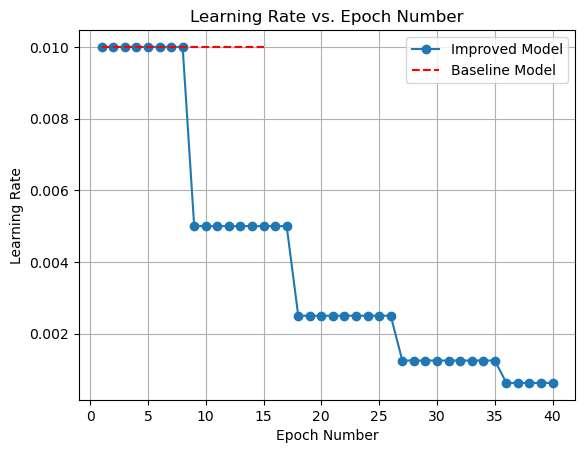

In [6]:
baseline = [0.01] * 15

# Plot improved model (all 50 epochs)
plt.plot(range(1, num_epochs + 1), learning_rates, marker='o', linestyle='-', label="Improved Model")
# Plot baseline model (up to epoch 15)
plt.plot(range(1, 16), baseline, linestyle='--', color='red', label="Baseline Model")
plt.title("Learning Rate vs. Epoch Number")
plt.xlabel("Epoch Number")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()